## Fisher's Linear Discriminant Analysis + ANN

### Imports

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.metrics import accuracy_score, mean_squared_error
from joblib import dump, load
from tensorflow.keras.models import load_model
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, Conv1D
import numpy as np
import os
import pickle

### Loading dataset

In [9]:
# Load the dataset
mat = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines.mat')
mat_gt = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines_gt.mat')

data = mat['indian_pines']
labels = mat_gt['indian_pines_gt']

# Reshape the data to (num_samples, num_features)
n, m, num_samples = data.shape
data_reshaped = np.reshape(data, (n*m, num_samples))
labels_reshaped = np.reshape(labels, (n*m,))

### Saving dataset image

In [10]:
def save_fig(img, name, dir = '../output/lda/', keep_axis = True):
    _ , ax = plt.subplots(figsize=(4,4), dpi=100)
    ax.imshow(img, interpolation='nearest')
    if not keep_axis:
        ax.set_axis_off()
    # ax.xaxis.set_major_locator(plt.NullLocator())
    # ax.yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(os.path.join(dir,name), bbox_inches='tight', pad_inches=0, transparent=True, edgecolor='none', facecolor='none')

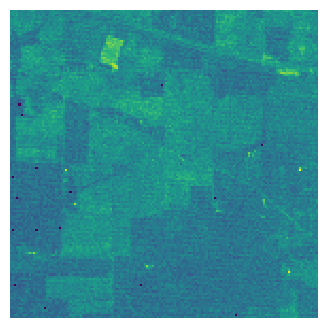

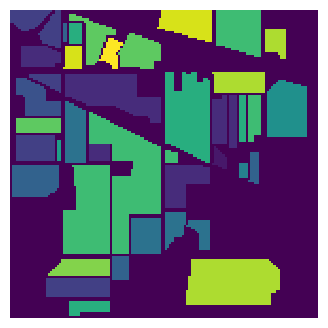

In [11]:
save_fig(data[:,:,1], name='indian_pines.png', dir='../dataset/Indian Pines/', keep_axis=False)
save_fig(labels, name='indian_pines_gt.png', dir='../dataset/Indian Pines/', keep_axis=False)

### Preprocessing the dataset

In [12]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

data_scaled = StandardScaler().fit_transform(data_reshaped)

### Fisher's LDA

In [14]:
import numpy as np

def lda(X, y, num_components):
    # compute class means
    means = []
    for c in np.unique(y):
        means.append(np.mean(X[y == c], axis=0))
    
    # compute within-class scatter matrix
    Sw = np.zeros((X.shape[1], X.shape[1]))
    for c, mean in zip(np.unique(y), means):
        class_sc_mat = np.zeros((X.shape[1], X.shape[1]))  
        for row in X[y == c]:
            row, mean = row.reshape(X.shape[1],1), mean.reshape(X.shape[1],1) 
            class_sc_mat += (row-mean).dot((row-mean).T)
        Sw += class_sc_mat  
    
    # compute between-class scatter matrix
    Sb = np.zeros((X.shape[1], X.shape[1]))
    grand_mean = np.mean(X, axis=0).reshape(X.shape[1],1)
    for c, mean in zip(np.unique(y), means):
        n = X[y==c,:].shape[0]
        mean = mean.reshape(X.shape[1],1)
        Sb += n * (mean - grand_mean).dot((mean - grand_mean).T)
    
    # compute eigenvalues and eigenvectors of Sw^-1*Sb
    eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
    eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
    
    # extract the top k eigenvectors as LDA components
    lda_components = np.zeros((X.shape[1], num_components))
    for i in range(num_components):
        lda_components[:, i] = eigen_pairs[i][1]
    
    # project data onto the LDA components
    X_lda = X.dot(lda_components)
    
    return X_lda, lda_components


# Apply LDA to reduce the dimensionality of the data
num_components = 16
data_lda, lda_components = lda(data_scaled, labels.ravel(), num_components)

# with open('../models/lda_model.pkl', 'wb') as f:
#     pickle.dump(lda_components, f)

# save_fig(data_lda[:,0].reshape(n,m), name='lda_1.png', dir='../output/lda/', keep_axis=False)
# save_fig(data_lda[:,1].reshape(n,m), name='lda_2.png', dir='../output/lda/', keep_axis=False)
# save_fig(data_lda[:,2].reshape(n,m), name='lda_3.png', dir='../output/lda/', keep_axis=False)

/tmp/ipykernel_94762/1666847838.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  lda_components[:, i] = eigen_pairs[i][1]


### Model

In [21]:
# Define the neural network architecture
print(data_lda.shape[1])
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=data_lda.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(17, activation='softmax'))

model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

16
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                1088      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 17)                561       
                                                                 
Total params: 3,729
Trainable params: 3,729
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Training

In [16]:
# Convert labels to one-hot encoding
num_labels = len(np.unique(labels_reshaped))
labels_onehot = np.eye(num_labels)[labels_reshaped.reshape(-1)]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_lda, labels_onehot, test_size=0.3, random_state=42)

# Train the neural network on the training set
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the neural network on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)

# model.save('../models/lda_ann.h5')

Epoch 1/50
368/368 [==============================] - 1s 2ms/step - loss: 1.4667 - accuracy: 0.5845 - val_loss: 1.0025 - val_accuracy: 0.6807
Epoch 2/50
368/368 [==============================] - 1s 1ms/step - loss: 0.8621 - accuracy: 0.7075 - val_loss: 0.8051 - val_accuracy: 0.7201
Epoch 3/50
368/368 [==============================] - 1s 1ms/step - loss: 0.7513 - accuracy: 0.7335 - val_loss: 0.7372 - val_accuracy: 0.7310
Epoch 4/50
368/368 [==============================] - 1s 2ms/step - loss: 0.7048 - accuracy: 0.7420 - val_loss: 0.7056 - val_accuracy: 0.7327
Epoch 5/50
368/368 [==============================] - 1s 2ms/step - loss: 0.6793 - accuracy: 0.7443 - val_loss: 0.6778 - val_accuracy: 0.7449
Epoch 6/50
368/368 [==============================] - 1s 1ms/step - loss: 0.6580 - accuracy: 0.7522 - val_loss: 0.6528 - val_accuracy: 0.7493
Epoch 7/50
368/368 [==============================] - 1s 1ms/step - loss: 0.6430 - accuracy: 0.7577 - val_loss: 0.6430 - val_accuracy: 0.7503
Epoch 

### Prediction

658/658 [==============================] - 1s 834us/step
Clustered labels accuracy: 0.7951961950059453
MSE: 20.353674197384066


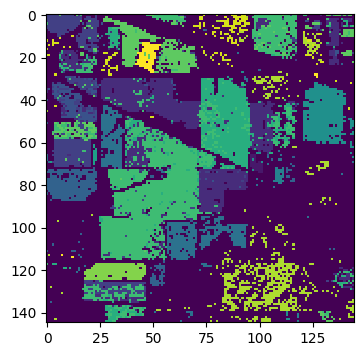

In [67]:
# Reshape the cluster labels and display the segmented image
pred_labels_onehot = model.predict(data_lda)
# smoothed_preds = np.apply_along_axis(lambda x: np.convolve(x, [1/3, 1/3, 1/3], mode='same'), axis=1, arr=cluster_labels_onehot)
pred_labels = np.argmax(pred_labels_onehot, axis=1)

pred_labels_reshaped = np.reshape(pred_labels, (n, m))
accuracy = np.mean(pred_labels_reshaped == labels)
print("Clustered labels accuracy:", accuracy)

cluster_labels_flat = np.reshape(pred_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
save_fig(pred_labels_reshaped, name='lda_nn_without_gauss.png')

### Gauss Smoothening

658/658 [==============================] - 1s 833us/step


100%|██████████| 299/299 [00:00<00:00, 563.20it/s]


Best sigma=1.0 with accuracy=0.8419
MSE: 22.99510107015458


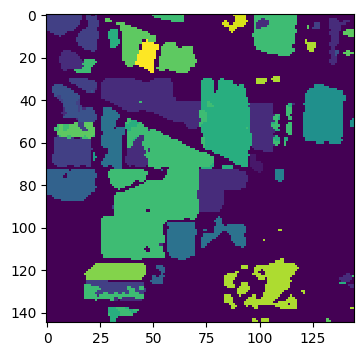

In [68]:
import cv2
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

sigmas = np.arange(0.01, 3.00, 0.01)  # different values of sigma to try
best_accuracy = 0
best_sigma = 0

# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_lda)
preds = np.reshape(cluster_labels_onehot, (n, m, 17))

for sigma in tqdm(sigmas):
    smoothed_preds = cv2.GaussianBlur(preds, (0, 0), sigma)

    cluster_labels_reshaped = np.argmax(smoothed_preds, axis=2)
    accuracy = np.mean(cluster_labels_reshaped == labels)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sigma = sigma
        best_image = cluster_labels_reshaped

print(f"Best sigma={best_sigma:.1f} with accuracy={best_accuracy:.4f}")

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
save_fig(best_image, name='lda_nn_with_gauss.png')

In [31]:
# pipeline = load('lda_pipeline.joblib')    
# data_lda = pipeline.predict(data_reshaped)

# # Create a new array with shape (n, n, 17)
# stacked_array = np.zeros((data_lda.shape[0], 16))

# # Stack the image 17 times along the last axis
# for i in range(16):
#     stacked_array[:, i] = data_lda

# data_lda = stacked_array

# model = load_model('lda_model.h5')
# cluster_labels_onehot = model.predict(data_lda)

# preds = np.reshape(cluster_labels_onehot, (n, m, 17))

# for sigma in tqdm(sigmas):
#     smoothed_preds = cv2.GaussianBlur(preds, (0, 0), sigma)

#     cluster_labels_reshaped = np.argmax(smoothed_preds, axis=2)
#     accuracy = np.mean(cluster_labels_reshaped == labels)

#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_sigma = sigma
#         best_image = cluster_labels_reshaped

# print(f"Best sigma={best_sigma:.1f} with accuracy={best_accuracy:.4f}")

# cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
# mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
# print("MSE:", mse)
# plt.imshow(best_image)
# plt.show()
